In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
from model_mnist import LeNet5, LinAutoencoder, ConvAutoencoder
from visualize import *
import autoencoder 
import dset_mnist as dset
import foolbox
sys.path.append('../trim')
from transforms_torch import transform_bandpass, tensor_t_augment, batch_fftshift2d, batch_ifftshift2d
from trim import *
from util import *
from attributions import *
from captum.attr import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
# set args
args = dset.get_args()
args.cuda = True

# load mnist data
train_loader, test_loader = dset.load_data(args.batch_size, args.test_batch_size, device)

# load model
m = LeNet5().eval()
m.load_state_dict(torch.load('weights/lenet_epoch=12_test_acc=0.991.pth'))
m = m.to(device)

# test model
dset.test(m, test_loader, args)


Test set: Average loss: 0.0306, Accuracy: 9907/10000 (99.07%)



# autoencoder

In [3]:
lamb_grid = np.geomspace(1e-6, 0.5, 20)
Losses = []
tLosses = []

# number of epochs to train the model
num_epochs = 20

for i,lamb in enumerate(lamb_grid):
    print(i)
    # initialize the NN
    model = ConvAutoencoder().to(device)

    # prepend model
    m_t = TrimModel(m, model.i_transformer, use_residuals=True)

    losses = []
    tlosses = []
    num_delay = 0
    
    best_loss = 1e+10

    # actually do training
    for epoch in range(1, num_epochs + 1):
        model, train_loss = autoencoder.train(epoch, train_loader, model, m_t, lamb)
        test_loss = autoencoder.test(test_loader, model, m_t, lamb)

        # print avg training statistics 
        train_loss = train_loss/len(train_loader.dataset)
        test_loss = test_loss/len(test_loader.dataset)
        print('\nEpoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss))
        losses.append(train_loss)
        tlosses.append(test_loss)
        if test_loss <= best_loss:
            best_loss = test_loss
            num_delay = 0
        else:
            num_delay += 1

#         if num_delay == 3:
#             break
            
    torch.save(model.state_dict(), 'results/autoencoder_conv_layer_supervised/transform_' + str(np.around(lamb, 6)))              
    Losses.append(losses)
    tLosses.append(tlosses)
    

0
Train Epoch: 1 [29984/60000 (100%)]	Loss: 0.089313
Epoch: 1 	Training Loss: 0.686743
Train Epoch: 2 [29984/60000 (100%)]	Loss: 0.002879
Epoch: 2 	Training Loss: 0.030640
Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.010443
Epoch: 3 	Training Loss: 0.020749
Train Epoch: 4 [29984/60000 (100%)]	Loss: 0.001208
Epoch: 4 	Training Loss: 0.018129
Train Epoch: 5 [29984/60000 (100%)]	Loss: 0.001832
Epoch: 5 	Training Loss: 0.016692
Train Epoch: 6 [29984/60000 (100%)]	Loss: 0.001649
Epoch: 6 	Training Loss: 0.015866
Train Epoch: 7 [29984/60000 (100%)]	Loss: 0.004612
Epoch: 7 	Training Loss: 0.015305
Train Epoch: 8 [29984/60000 (100%)]	Loss: 0.004806
Epoch: 8 	Training Loss: 0.014911
Train Epoch: 9 [29984/60000 (100%)]	Loss: 0.009864
Epoch: 9 	Training Loss: 0.014550
Train Epoch: 10 [29984/60000 (100%)]	Loss: 0.013110
Epoch: 10 	Training Loss: 0.014227
Train Epoch: 11 [29984/60000 (100%)]	Loss: 0.021325
Epoch: 11 	Training Loss: 0.014021
Train Epoch: 12 [29984/60000 (100%)]	Loss: 0.001462
Epoch: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 8 [29984/60000 (100%)]	Loss: 0.000127
Epoch: 8 	Training Loss: 0.014011
Train Epoch: 9 [29984/60000 (100%)]	Loss: 0.001896
Epoch: 9 	Training Loss: 0.013650
Train Epoch: 10 [29984/60000 (100%)]	Loss: 0.071475
Epoch: 10 	Training Loss: 0.013353
Train Epoch: 11 [43456/60000 (72%)]	Loss: 0.003056

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 15 [29984/60000 (100%)]	Loss: 0.004128
Epoch: 15 	Training Loss: 0.012526
Train Epoch: 16 [29984/60000 (100%)]	Loss: 0.087092
Epoch: 16 	Training Loss: 0.012456
Train Epoch: 17 [29984/60000 (100%)]	Loss: 0.000668
Epoch: 17 	Training Loss: 0.012352
Train Epoch: 18 [37184/60000 (62%)]	Loss: 0.001356

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 4 [29984/60000 (100%)]	Loss: 0.007623
Epoch: 4 	Training Loss: 0.019611
Train Epoch: 5 [29984/60000 (100%)]	Loss: 0.000142
Epoch: 5 	Training Loss: 0.017972
Train Epoch: 6 [29984/60000 (100%)]	Loss: 0.000612
Epoch: 6 	Training Loss: 0.016829
Train Epoch: 7 [29984/60000 (100%)]	Loss: 0.002414
Epoch: 7 	Training Loss: 0.016044
Train Epoch: 8 [56000/60000 (93%)]	Loss: 0.004608

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 12 [29984/60000 (100%)]	Loss: 0.000299
Epoch: 12 	Training Loss: 0.014026
Train Epoch: 13 [29984/60000 (100%)]	Loss: 0.001209
Epoch: 13 	Training Loss: 0.013792
Train Epoch: 14 [29984/60000 (100%)]	Loss: 0.000520
Epoch: 14 	Training Loss: 0.013626
Train Epoch: 15 [29984/60000 (100%)]	Loss: 0.000323
Epoch: 15 	Training Loss: 0.013509
Train Epoch: 16 [29984/60000 (100%)]	Loss: 0.000596
Epoch: 16 	Training Loss: 0.013388
Train Epoch: 17 [29984/60000 (100%)]	Loss: 0.001532
Epoch: 17 	Training Loss: 0.013268
Train Epoch: 18 [4992/60000 (8%)]	Loss: 0.021048

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 2 [29984/60000 (100%)]	Loss: 0.242339
Epoch: 2 	Training Loss: 0.032224
Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.033396
Epoch: 3 	Training Loss: 0.022079
Train Epoch: 4 [29984/60000 (100%)]	Loss: 0.004493
Epoch: 4 	Training Loss: 0.019257
Train Epoch: 5 [29984/60000 (100%)]	Loss: 0.034397
Epoch: 5 	Training Loss: 0.017793
Train Epoch: 6 [15936/60000 (27%)]	Loss: 0.013427

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 9 [29984/60000 (100%)]	Loss: 0.000729
Epoch: 9 	Training Loss: 0.015071
Train Epoch: 10 [29984/60000 (100%)]	Loss: 0.000802
Epoch: 10 	Training Loss: 0.014739
Train Epoch: 11 [29984/60000 (100%)]	Loss: 0.001259
Epoch: 11 	Training Loss: 0.014441
Train Epoch: 12 [25792/60000 (43%)]	Loss: 0.009869

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 16 [29984/60000 (100%)]	Loss: 0.028331
Epoch: 16 	Training Loss: 0.013538
Train Epoch: 17 [29984/60000 (100%)]	Loss: 0.031011
Epoch: 17 	Training Loss: 0.013454
Train Epoch: 18 [29984/60000 (100%)]	Loss: 0.000814
Epoch: 18 	Training Loss: 0.013308
Train Epoch: 19 [29984/60000 (100%)]	Loss: 0.007144
Epoch: 19 	Training Loss: 0.013247
Train Epoch: 20 [33408/60000 (56%)]	Loss: 0.015592

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.005665
Epoch: 3 	Training Loss: 0.021042
Train Epoch: 4 [29984/60000 (100%)]	Loss: 0.004467
Epoch: 4 	Training Loss: 0.017868
Train Epoch: 5 [29984/60000 (100%)]	Loss: 0.068493
Epoch: 5 	Training Loss: 0.016073
Train Epoch: 6 [29984/60000 (100%)]	Loss: 0.000689
Epoch: 6 	Training Loss: 0.015072
Train Epoch: 7 [1728/60000 (3%)]	Loss: 0.001073

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 13 [29984/60000 (100%)]	Loss: 0.001712
Epoch: 13 	Training Loss: 0.012931
Train Epoch: 14 [29984/60000 (100%)]	Loss: 0.000345
Epoch: 14 	Training Loss: 0.012855
Train Epoch: 15 [29984/60000 (100%)]	Loss: 0.006317
Epoch: 15 	Training Loss: 0.012747
Train Epoch: 16 [26304/60000 (44%)]	Loss: 0.001515

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 1 [29984/60000 (100%)]	Loss: 0.005899
Epoch: 1 	Training Loss: 0.758544
Train Epoch: 2 [29984/60000 (100%)]	Loss: 0.013095
Epoch: 2 	Training Loss: 0.024865
Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.002085
Epoch: 3 	Training Loss: 0.018571
Train Epoch: 4 [29984/60000 (100%)]	Loss: 0.004786
Epoch: 4 	Training Loss: 0.016994
Train Epoch: 5 [51520/60000 (86%)]	Loss: 0.002668

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 9 [29984/60000 (100%)]	Loss: 0.000158
Epoch: 9 	Training Loss: 0.014444
Train Epoch: 10 [29984/60000 (100%)]	Loss: 0.004075
Epoch: 10 	Training Loss: 0.014296
Train Epoch: 11 [29984/60000 (100%)]	Loss: 0.064077
Epoch: 11 	Training Loss: 0.014099
Train Epoch: 12 [53440/60000 (89%)]	Loss: 0.046352

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 17 [29984/60000 (100%)]	Loss: 0.005558
Epoch: 17 	Training Loss: 0.013360
Train Epoch: 18 [29984/60000 (100%)]	Loss: 0.000118
Epoch: 18 	Training Loss: 0.013340
Train Epoch: 19 [29984/60000 (100%)]	Loss: 0.000596
Epoch: 19 	Training Loss: 0.013207
Train Epoch: 20 [30272/60000 (50%)]	Loss: 0.017677

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 4 [29984/60000 (100%)]	Loss: 0.002091
Epoch: 4 	Training Loss: 0.017093
Train Epoch: 5 [29984/60000 (100%)]	Loss: 0.001239
Epoch: 5 	Training Loss: 0.015491
Train Epoch: 6 [29984/60000 (100%)]	Loss: 0.000922
Epoch: 6 	Training Loss: 0.014569
Train Epoch: 7 [46592/60000 (78%)]	Loss: 0.004851

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 11 [29984/60000 (100%)]	Loss: 0.009337
Epoch: 11 	Training Loss: 0.012770
Train Epoch: 12 [29984/60000 (100%)]	Loss: 0.039623
Epoch: 12 	Training Loss: 0.012642
Train Epoch: 13 [29984/60000 (100%)]	Loss: 0.001630
Epoch: 13 	Training Loss: 0.012528
Train Epoch: 14 [29984/60000 (100%)]	Loss: 0.127134
Epoch: 14 	Training Loss: 0.012432
Train Epoch: 15 [704/60000 (1%)]	Loss: 0.002813

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 18 [29984/60000 (100%)]	Loss: 0.001544
Epoch: 18 	Training Loss: 0.012118
Train Epoch: 19 [29984/60000 (100%)]	Loss: 0.001135
Epoch: 19 	Training Loss: 0.012058
Train Epoch: 20 [29984/60000 (100%)]	Loss: 0.000193
Epoch: 20 	Training Loss: 0.011992
8
Train Epoch: 1 [5056/60000 (8%)]	Loss: 2.311236

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.002927

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 6 [29984/60000 (100%)]	Loss: 0.001433
Epoch: 6 	Training Loss: 0.015125
Train Epoch: 7 [29984/60000 (100%)]	Loss: 0.003818
Epoch: 7 	Training Loss: 0.014659
Train Epoch: 8 [29984/60000 (100%)]	Loss: 0.041736
Epoch: 8 	Training Loss: 0.014299
Train Epoch: 9 [29984/60000 (100%)]	Loss: 0.001832
Epoch: 9 	Training Loss: 0.014183
Train Epoch: 10 [29984/60000 (100%)]	Loss: 0.000753
Epoch: 10 	Training Loss: 0.014041
Train Epoch: 11 [40704/60000 (68%)]	Loss: 0.010707

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 17 [29984/60000 (100%)]	Loss: 0.000120
Epoch: 17 	Training Loss: 0.013354
Train Epoch: 18 [29984/60000 (100%)]	Loss: 0.000294
Epoch: 18 	Training Loss: 0.013230
Train Epoch: 19 [29984/60000 (100%)]	Loss: 0.034178
Epoch: 19 	Training Loss: 0.013192
Train Epoch: 20 [54080/60000 (90%)]	Loss: 0.000758

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 5 [29984/60000 (100%)]	Loss: 0.000305
Epoch: 5 	Training Loss: 0.015547
Train Epoch: 6 [29984/60000 (100%)]	Loss: 0.002392
Epoch: 6 	Training Loss: 0.014980
Train Epoch: 7 [29984/60000 (100%)]	Loss: 0.016840
Epoch: 7 	Training Loss: 0.014567
Train Epoch: 8 [29984/60000 (100%)]	Loss: 0.019833
Epoch: 8 	Training Loss: 0.014303
Train Epoch: 9 [59584/60000 (99%)]	Loss: 0.016225

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 13 [29984/60000 (100%)]	Loss: 0.002305
Epoch: 13 	Training Loss: 0.013372
Train Epoch: 14 [29984/60000 (100%)]	Loss: 0.004086
Epoch: 14 	Training Loss: 0.013273
Train Epoch: 15 [29984/60000 (100%)]	Loss: 0.000677
Epoch: 15 	Training Loss: 0.013143
Train Epoch: 16 [29984/60000 (100%)]	Loss: 0.005482
Epoch: 16 	Training Loss: 0.013061
Train Epoch: 17 [29984/60000 (100%)]	Loss: 0.008741
Epoch: 17 	Training Loss: 0.012968
Train Epoch: 18 [960/60000 (2%)]	Loss: 0.003952

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.003619
Epoch: 3 	Training Loss: 0.020512
Train Epoch: 4 [29984/60000 (100%)]	Loss: 0.005050
Epoch: 4 	Training Loss: 0.016906
Train Epoch: 5 [29984/60000 (100%)]	Loss: 0.015031
Epoch: 5 	Training Loss: 0.015670
Train Epoch: 6 [25024/60000 (42%)]	Loss: 0.056497

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 11 [29984/60000 (100%)]	Loss: 0.008909
Epoch: 11 	Training Loss: 0.013756
Train Epoch: 12 [29984/60000 (100%)]	Loss: 0.000773
Epoch: 12 	Training Loss: 0.013625
Train Epoch: 13 [29984/60000 (100%)]	Loss: 0.001925
Epoch: 13 	Training Loss: 0.013490
Train Epoch: 14 [29984/60000 (100%)]	Loss: 0.016614
Epoch: 14 	Training Loss: 0.013383
Train Epoch: 15 [29632/60000 (49%)]	Loss: 0.057924

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 20 [29984/60000 (100%)]	Loss: 0.000453
Epoch: 20 	Training Loss: 0.012780
11
Train Epoch: 1 [29984/60000 (100%)]	Loss: 0.076871
Epoch: 1 	Training Loss: 0.837864
Train Epoch: 2 [29984/60000 (100%)]	Loss: 0.003048
Epoch: 2 	Training Loss: 0.028604
Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.000914
Epoch: 3 	Training Loss: 0.019533
Train Epoch: 4 [27712/60000 (46%)]	Loss: 0.005898

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 8 [29984/60000 (100%)]	Loss: 0.000944
Epoch: 8 	Training Loss: 0.013600
Train Epoch: 9 [29984/60000 (100%)]	Loss: 0.020064
Epoch: 9 	Training Loss: 0.013286
Train Epoch: 10 [29984/60000 (100%)]	Loss: 0.013821
Epoch: 10 	Training Loss: 0.013087
Train Epoch: 11 [29984/60000 (100%)]	Loss: 0.001326
Epoch: 11 	Training Loss: 0.012893
Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.008209

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 16 [29984/60000 (100%)]	Loss: 0.035854
Epoch: 16 	Training Loss: 0.012363
Train Epoch: 17 [29984/60000 (100%)]	Loss: 0.022989
Epoch: 17 	Training Loss: 0.012298
Train Epoch: 18 [29984/60000 (100%)]	Loss: 0.036940
Epoch: 18 	Training Loss: 0.012251
Train Epoch: 1 [29984/60000 (100%)]	Loss: 0.087083
Epoch: 1 	Training Loss: 0.705673
Train Epoch: 2 [29984/60000 (100%)]	Loss: 0.011563
Epoch: 2 	Training Loss: 0.029385
Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.041149
Epoch: 3 	Training Loss: 0.021686
Train Epoch: 4 [29984/60000 (100%)]	Loss: 0.002227
Epoch: 4 	Training Loss: 0.018970
Train Epoch: 5 [29984/60000 (100%)]	Loss: 0.001590
Epoch: 5 	Training Loss: 0.017308
Train Epoch: 6 [29984/60000 (100%)]	Loss: 0.000545
Epoch: 6 	Training Loss: 0.016154
Train Epoch: 7 [29984/60000 (100%)]	Loss: 0.040042
Epoch: 7 	Training Loss: 0.015469
Train Epoch: 8 [29984/60000 (100%)]	Loss: 0.000789
Epoch: 8 	Training Loss: 0.014948
Train Epoch: 9 [29984/60000 (100%)]	Loss: 0.000905
Epoch: 9

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 11 [29984/60000 (100%)]	Loss: 0.005227
Epoch: 11 	Training Loss: 0.016699
Train Epoch: 12 [29984/60000 (100%)]	Loss: 0.005916
Epoch: 12 	Training Loss: 0.016460
Train Epoch: 13 [29984/60000 (100%)]	Loss: 0.013063
Epoch: 13 	Training Loss: 0.016258
Train Epoch: 14 [29984/60000 (100%)]	Loss: 0.003322
Epoch: 14 	Training Loss: 0.016072
Train Epoch: 15 [29984/60000 (100%)]	Loss: 0.022887
Epoch: 15 	Training Loss: 0.015889
Train Epoch: 16 [128/60000 (0%)]	Loss: 0.023780

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 20 [29984/60000 (100%)]	Loss: 0.002918
Epoch: 20 	Training Loss: 0.015135
18
Train Epoch: 1 [29984/60000 (100%)]	Loss: 0.046068
Epoch: 1 	Training Loss: 0.857787
Train Epoch: 2 [29984/60000 (100%)]	Loss: 0.007989
Epoch: 2 	Training Loss: 0.036422
Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.007300
Epoch: 3 	Training Loss: 0.025934
Train Epoch: 4 [29984/60000 (100%)]	Loss: 0.023921
Epoch: 4 	Training Loss: 0.024192
Train Epoch: 5 [18112/60000 (30%)]	Loss: 0.057021

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 8 [29984/60000 (100%)]	Loss: 0.011207
Epoch: 8 	Training Loss: 0.021098
Train Epoch: 9 [29984/60000 (100%)]	Loss: 0.016079
Epoch: 9 	Training Loss: 0.020648
Train Epoch: 10 [29984/60000 (100%)]	Loss: 0.009456
Epoch: 10 	Training Loss: 0.020122
Train Epoch: 11 [29984/60000 (100%)]	Loss: 0.021606
Epoch: 11 	Training Loss: 0.019926
Train Epoch: 12 [18688/60000 (31%)]	Loss: 0.010641

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 16 [29984/60000 (100%)]	Loss: 0.007778
Epoch: 16 	Training Loss: 0.018567
Train Epoch: 17 [29984/60000 (100%)]	Loss: 0.007183
Epoch: 17 	Training Loss: 0.018397
Train Epoch: 18 [29984/60000 (100%)]	Loss: 0.006380
Epoch: 18 	Training Loss: 0.018378
Train Epoch: 19 [32960/60000 (55%)]	Loss: 0.007481

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.017146
Epoch: 3 	Training Loss: 0.032706
Train Epoch: 4 [29984/60000 (100%)]	Loss: 0.040973
Epoch: 4 	Training Loss: 0.029707
Train Epoch: 5 [29984/60000 (100%)]	Loss: 0.012621
Epoch: 5 	Training Loss: 0.028063
Train Epoch: 6 [50560/60000 (84%)]	Loss: 0.012215

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Epoch: 7 [29984/60000 (100%)]	Loss: 0.040328
Epoch: 7 	Training Loss: 0.025911
Train Epoch: 8 [29984/60000 (100%)]	Loss: 0.009942
Epoch: 8 	Training Loss: 0.025041
Train Epoch: 9 [29984/60000 (100%)]	Loss: 0.012426
Epoch: 9 	Training Loss: 0.024439
Train Epoch: 10 [29984/60000 (100%)]	Loss: 0.018190
Epoch: 10 	Training Loss: 0.023834
Train Epoch: 11 [29984/60000 (100%)]	Loss: 0.032578
Epoch: 11 	Training Loss: 0.023354
Train Epoch: 12 [29984/60000 (100%)]	Loss: 0.008703
Epoch: 12 	Training Loss: 0.022954
Train Epoch: 13 [29984/60000 (100%)]	Loss: 0.010705
Epoch: 13 	Training Loss: 0.022596
Train Epoch: 14 [29984/60000 (100%)]	Loss: 0.010945
Epoch: 14 	Training Loss: 0.022156
Train Epoch: 15 [29984/60000 (100%)]	Loss: 0.013720
Epoch: 15 	Training Loss: 0.021952
Train Epoch: 16 [29984/60000 (100%)]	Loss: 0.011435
Epoch: 16 	Training Loss: 0.021583
Train Epoch: 17 [29984/60000 (100%)]	Loss: 0.019669
Epoch: 17 	Training Loss: 0.021262
Train Epoch: 18 [29984/60000 (100%)]	Loss: 0.0920

7.9870176


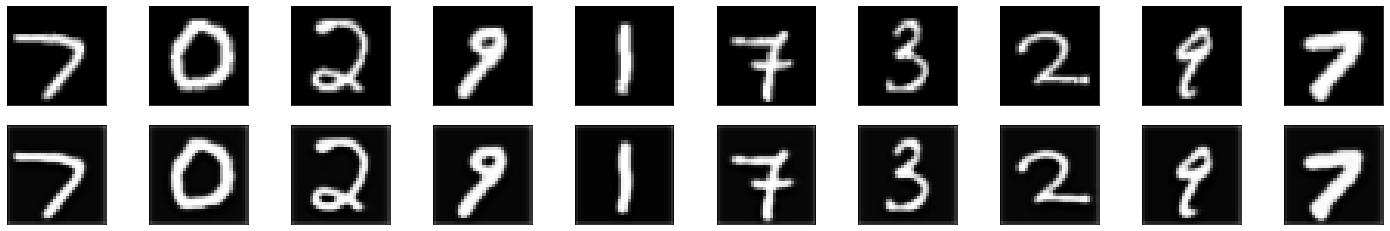

In [34]:
# load model
model.load_state_dict(torch.load('results/autoencoder_conv_layer_supervised/transform_' + str(np.around(lamb, 6))))

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images[70:80]
model = model.to('cpu')

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(10, 1, 32, 32)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

print(np.linalg.norm(output - images))

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# visualization

In [40]:
# load model
lamb = lamb_grid[-1]
model.load_state_dict(torch.load('results/autoencoder_conv_layer_supervised/transform_' + str(np.around(lamb, 6))))

<All keys matched successfully>

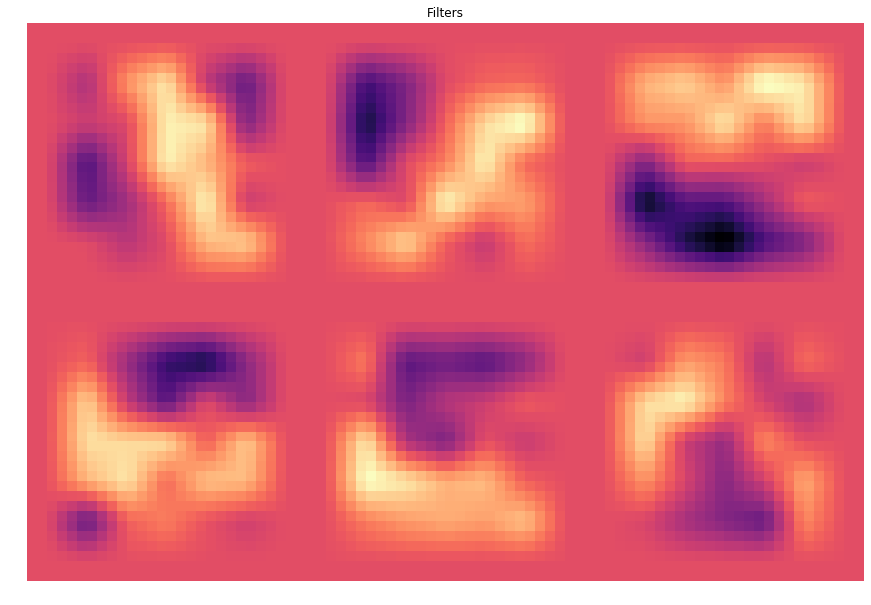

In [41]:
# viz filters
viz_tensors(m.convnet.c1.weight.squeeze(), n_row=2, n_col=3, normalize=False)

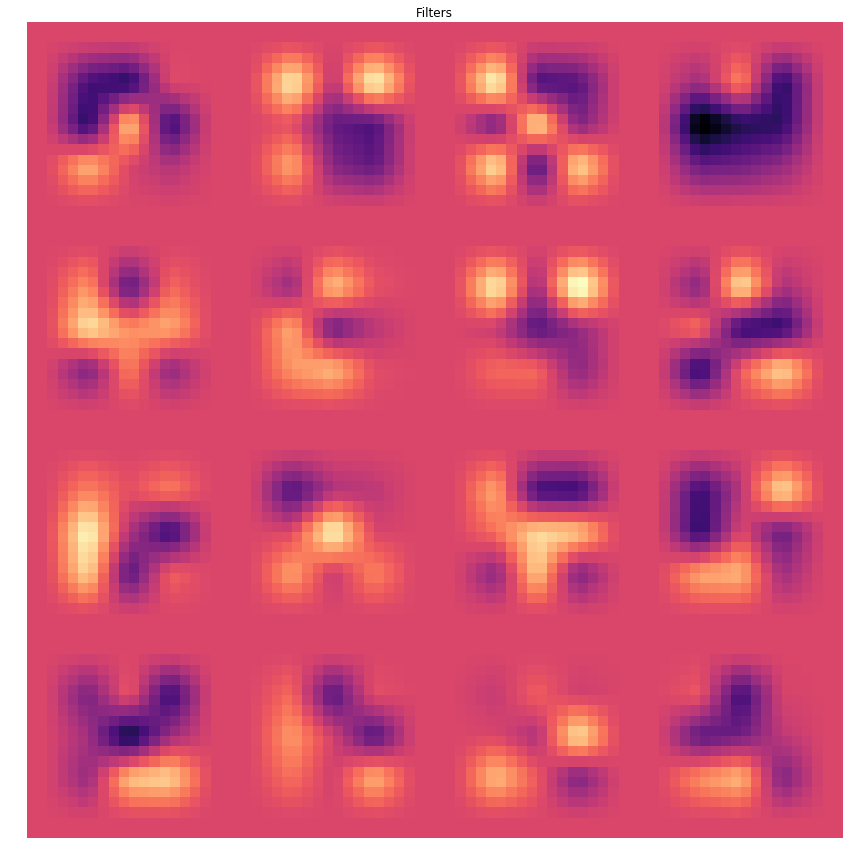

In [42]:
# viz filters
viz_tensors(model.conv1.weight, n_row=4, n_col=4, normalize=False)

In [43]:
# data
inputs, labels = iter(test_loader).next()
inputs = inputs.to(device)
labels = labels.to(device)

# get attributions
model = model.to(device)
m_t = TrimModel(m, model.i_transformer, use_residuals=True)

s = model.transformer(inputs)
attributer = InputXGradient(m_t)
# attributer = IntegratedGradients(m_t)        
attributions = attributer.attribute(s, target=labels, additional_forward_args=deepcopy(inputs))
# standardization
# mean = attributions.mean(dim=1, keepdim=True)
# std = attributions.std(dim=1, keepdim=True)
# attributions = (attributions - mean) / std   

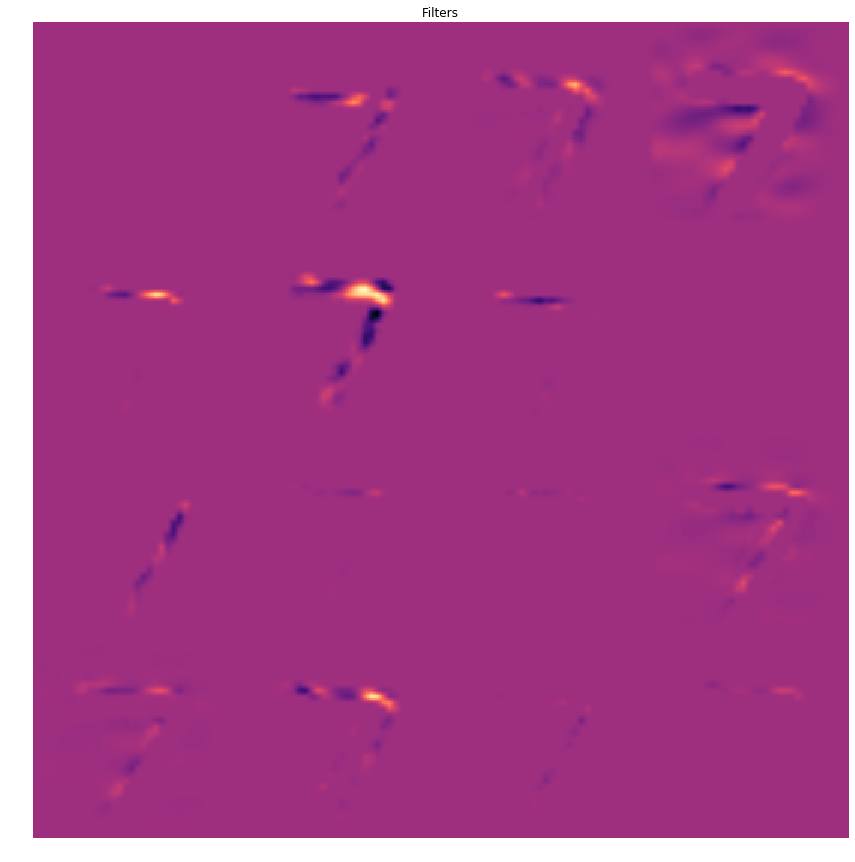

In [44]:
# viz filters
viz_tensors(attributions[0], n_row=4, n_col=4, normalize=False)